In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
import zipfile
with zipfile.ZipFile('/content/Tiny.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydataset')

In [ ]:
# # Define transformations for the dataset
# image_size=(224,224)
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                           std=[0.5, 0.5, 0.5]),
# ])

# transform_test = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#      transforms.ToTensor(),
#      transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                           std=[0.5, 0.5, 0.5]),
# ])


# Define transformations for the dataset
image_size=(224,224)
transform_train = transforms.Compose([
     transforms.ToTensor()
])

transform_test = transforms.Compose([
     transforms.ToTensor()
])

In [ ]:
# Define the data loaders
# Load the dataset
train_dataset = datasets.ImageFolder(root='/content/mydataset/Tiny/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='/content/mydataset/Tiny/validation', transform=transform_train)
test_dataset = datasets.ImageFolder(root='/content/mydataset/Tiny/test', transform=transform_test)

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True, drop_last=False,num_workers=4)
val_loader = DataLoader(train_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128,shuffle=False, drop_last=False,num_workers=4)

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

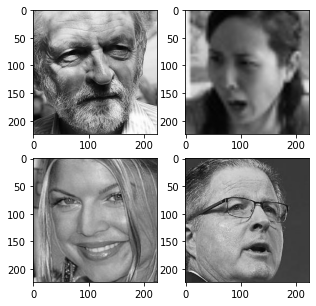

In [ ]:
plot_data_loader(train_loader, (2, 2))

In [ ]:
train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Train Size: 9620
Test Size: 2990
Validation Size: 2470


In [ ]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 13


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#lr_sched = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Define the function for training the model
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

# Define the function for validating the model
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    return epoch_loss, epoch_acc


from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
train_accs = []
val_losses = []
val_accs = []
# Train and validate the model for 70 epochs
num_epochs = 70
for epoch in range(num_epochs):
    # Train the model
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    
    # Validate the model
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    
    # Print the results
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    # Step the learning rate scheduler
    #lr_sched.step()
    # Show progress bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            pbar.update(1)


Epoch 1/70 | Train Loss: 2.1307 | Train Acc: 0.1707 | Val Loss: 4.8888 | Val Acc: 0.0816


Epoch 1/70: 100%|██████████| 76/76 [00:27<00:00,  2.80batch/s]


Epoch 2/70 | Train Loss: 2.1471 | Train Acc: 0.1677 | Val Loss: 4.7434 | Val Acc: 0.0791


Epoch 2/70: 100%|██████████| 76/76 [00:27<00:00,  2.75batch/s]


Epoch 3/70 | Train Loss: 2.0976 | Train Acc: 0.1769 | Val Loss: 2.1929 | Val Acc: 0.1690


Epoch 3/70: 100%|██████████| 76/76 [00:27<00:00,  2.81batch/s]


Epoch 4/70 | Train Loss: 2.1468 | Train Acc: 0.1729 | Val Loss: 3.0441 | Val Acc: 0.0799


Epoch 4/70: 100%|██████████| 76/76 [00:27<00:00,  2.81batch/s]


Epoch 5/70 | Train Loss: 2.0804 | Train Acc: 0.1833 | Val Loss: 3.5996 | Val Acc: 0.0779


Epoch 5/70: 100%|██████████| 76/76 [00:27<00:00,  2.74batch/s]


Epoch 6/70 | Train Loss: 2.0657 | Train Acc: 0.2045 | Val Loss: 2.6654 | Val Acc: 0.1369


Epoch 6/70: 100%|██████████| 76/76 [00:27<00:00,  2.79batch/s]


Epoch 7/70 | Train Loss: 2.1005 | Train Acc: 0.1789 | Val Loss: 2.0905 | Val Acc: 0.1905


Epoch 7/70: 100%|██████████| 76/76 [00:27<00:00,  2.79batch/s]


Epoch 8/70 | Train Loss: 2.0326 | Train Acc: 0.2038 | Val Loss: 1.9524 | Val Acc: 0.2139


Epoch 8/70: 100%|██████████| 76/76 [00:28<00:00,  2.70batch/s]


Epoch 9/70 | Train Loss: 2.0720 | Train Acc: 0.1982 | Val Loss: 3.6329 | Val Acc: 0.1356


Epoch 9/70: 100%|██████████| 76/76 [00:27<00:00,  2.77batch/s]


Epoch 10/70 | Train Loss: 2.0458 | Train Acc: 0.2057 | Val Loss: 4.9304 | Val Acc: 0.0783


Epoch 10/70: 100%|██████████| 76/76 [00:27<00:00,  2.78batch/s]


Epoch 11/70 | Train Loss: 2.2579 | Train Acc: 0.1748 | Val Loss: 2.9126 | Val Acc: 0.1409


Epoch 11/70: 100%|██████████| 76/76 [00:27<00:00,  2.79batch/s]


Epoch 12/70 | Train Loss: 2.0987 | Train Acc: 0.2041 | Val Loss: 4.3022 | Val Acc: 0.0823


Epoch 12/70: 100%|██████████| 76/76 [00:27<00:00,  2.78batch/s]


Epoch 13/70 | Train Loss: 2.0856 | Train Acc: 0.2076 | Val Loss: 2.4205 | Val Acc: 0.1866


Epoch 13/70: 100%|██████████| 76/76 [00:26<00:00,  2.82batch/s]


Epoch 14/70 | Train Loss: 2.2811 | Train Acc: 0.1835 | Val Loss: 3.3170 | Val Acc: 0.0779


Epoch 14/70: 100%|██████████| 76/76 [00:27<00:00,  2.81batch/s]


Epoch 15/70 | Train Loss: 2.4305 | Train Acc: 0.1631 | Val Loss: 2.2886 | Val Acc: 0.1907


Epoch 15/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 16/70 | Train Loss: 2.0133 | Train Acc: 0.2482 | Val Loss: 2.9286 | Val Acc: 0.0841


Epoch 16/70: 100%|██████████| 76/76 [00:27<00:00,  2.74batch/s]


Epoch 17/70 | Train Loss: 1.9662 | Train Acc: 0.2624 | Val Loss: 2.0079 | Val Acc: 0.2537


Epoch 17/70: 100%|██████████| 76/76 [00:27<00:00,  2.74batch/s]


Epoch 18/70 | Train Loss: 1.9693 | Train Acc: 0.2720 | Val Loss: 2.2168 | Val Acc: 0.2448


Epoch 18/70: 100%|██████████| 76/76 [00:27<00:00,  2.78batch/s]


Epoch 19/70 | Train Loss: 1.8572 | Train Acc: 0.2923 | Val Loss: 3.3528 | Val Acc: 0.1352


Epoch 19/70: 100%|██████████| 76/76 [00:27<00:00,  2.76batch/s]


Epoch 20/70 | Train Loss: 1.8966 | Train Acc: 0.2850 | Val Loss: 3.1451 | Val Acc: 0.1827


Epoch 20/70: 100%|██████████| 76/76 [00:27<00:00,  2.74batch/s]


Epoch 21/70 | Train Loss: 1.9138 | Train Acc: 0.2906 | Val Loss: 3.2622 | Val Acc: 0.0964


Epoch 21/70: 100%|██████████| 76/76 [00:27<00:00,  2.77batch/s]


Epoch 22/70 | Train Loss: 1.8110 | Train Acc: 0.3141 | Val Loss: 1.7236 | Val Acc: 0.3395


Epoch 22/70: 100%|██████████| 76/76 [00:27<00:00,  2.78batch/s]


Epoch 23/70 | Train Loss: 1.8250 | Train Acc: 0.3182 | Val Loss: 2.0972 | Val Acc: 0.2893


Epoch 23/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 24/70 | Train Loss: 2.0332 | Train Acc: 0.2815 | Val Loss: 3.1440 | Val Acc: 0.2018


Epoch 24/70: 100%|██████████| 76/76 [00:27<00:00,  2.77batch/s]


Epoch 25/70 | Train Loss: 2.0258 | Train Acc: 0.2747 | Val Loss: 1.9015 | Val Acc: 0.3200


Epoch 25/70: 100%|██████████| 76/76 [00:27<00:00,  2.77batch/s]


Epoch 26/70 | Train Loss: 1.9736 | Train Acc: 0.2929 | Val Loss: 1.9927 | Val Acc: 0.2986


Epoch 26/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 27/70 | Train Loss: 1.8826 | Train Acc: 0.3151 | Val Loss: 1.7426 | Val Acc: 0.3475


Epoch 27/70: 100%|██████████| 76/76 [00:27<00:00,  2.75batch/s]


Epoch 28/70 | Train Loss: 1.8777 | Train Acc: 0.3130 | Val Loss: 2.7283 | Val Acc: 0.0985


Epoch 28/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 29/70 | Train Loss: 1.7006 | Train Acc: 0.3567 | Val Loss: 1.6895 | Val Acc: 0.3559


Epoch 29/70: 100%|██████████| 76/76 [00:28<00:00,  2.66batch/s]


Epoch 30/70 | Train Loss: 1.6674 | Train Acc: 0.3652 | Val Loss: 1.6895 | Val Acc: 0.3700


Epoch 30/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 31/70 | Train Loss: 1.6144 | Train Acc: 0.3797 | Val Loss: 1.5470 | Val Acc: 0.4086


Epoch 31/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 32/70 | Train Loss: 1.6096 | Train Acc: 0.3839 | Val Loss: 1.5641 | Val Acc: 0.4028


Epoch 32/70: 100%|██████████| 76/76 [00:28<00:00,  2.69batch/s]


Epoch 33/70 | Train Loss: 1.5344 | Train Acc: 0.4106 | Val Loss: 1.4746 | Val Acc: 0.4385


Epoch 33/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 34/70 | Train Loss: 1.4994 | Train Acc: 0.4170 | Val Loss: 1.4753 | Val Acc: 0.4240


Epoch 34/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 35/70 | Train Loss: 1.4613 | Train Acc: 0.4332 | Val Loss: 1.4375 | Val Acc: 0.4502


Epoch 35/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 36/70 | Train Loss: 1.4388 | Train Acc: 0.4462 | Val Loss: 1.3676 | Val Acc: 0.4719


Epoch 36/70: 100%|██████████| 76/76 [00:28<00:00,  2.67batch/s]


Epoch 37/70 | Train Loss: 1.3944 | Train Acc: 0.4589 | Val Loss: 1.3483 | Val Acc: 0.4780


Epoch 37/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 38/70 | Train Loss: 1.3562 | Train Acc: 0.4793 | Val Loss: 1.3248 | Val Acc: 0.4887


Epoch 38/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 39/70 | Train Loss: 1.3241 | Train Acc: 0.4878 | Val Loss: 1.2668 | Val Acc: 0.5111


Epoch 39/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 40/70 | Train Loss: 1.2876 | Train Acc: 0.5010 | Val Loss: 1.2514 | Val Acc: 0.5082


Epoch 40/70: 100%|██████████| 76/76 [00:28<00:00,  2.69batch/s]


Epoch 41/70 | Train Loss: 1.2464 | Train Acc: 0.5184 | Val Loss: 1.1893 | Val Acc: 0.5440


Epoch 41/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 42/70 | Train Loss: 1.2407 | Train Acc: 0.5167 | Val Loss: 1.2305 | Val Acc: 0.5191


Epoch 42/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 43/70 | Train Loss: 1.1772 | Train Acc: 0.5445 | Val Loss: 1.0947 | Val Acc: 0.5759


Epoch 43/70: 100%|██████████| 76/76 [00:28<00:00,  2.67batch/s]


Epoch 44/70 | Train Loss: 1.1256 | Train Acc: 0.5626 | Val Loss: 1.0889 | Val Acc: 0.5673


Epoch 44/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 45/70 | Train Loss: 1.0747 | Train Acc: 0.5809 | Val Loss: 1.0027 | Val Acc: 0.6148


Epoch 45/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 46/70 | Train Loss: 1.0387 | Train Acc: 0.5956 | Val Loss: 0.9756 | Val Acc: 0.6227


Epoch 46/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 47/70 | Train Loss: 1.0196 | Train Acc: 0.6043 | Val Loss: 1.0302 | Val Acc: 0.5950


Epoch 47/70: 100%|██████████| 76/76 [00:28<00:00,  2.70batch/s]


Epoch 48/70 | Train Loss: 0.9739 | Train Acc: 0.6263 | Val Loss: 1.0409 | Val Acc: 0.6000


Epoch 48/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 49/70 | Train Loss: 0.9034 | Train Acc: 0.6488 | Val Loss: 0.8906 | Val Acc: 0.6546


Epoch 49/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 50/70 | Train Loss: 0.8488 | Train Acc: 0.6771 | Val Loss: 0.7664 | Val Acc: 0.7072


Epoch 50/70: 100%|██████████| 76/76 [00:28<00:00,  2.68batch/s]


Epoch 51/70 | Train Loss: 0.8032 | Train Acc: 0.6904 | Val Loss: 0.7375 | Val Acc: 0.7156


Epoch 51/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 52/70 | Train Loss: 0.7294 | Train Acc: 0.7230 | Val Loss: 0.6585 | Val Acc: 0.7569


Epoch 52/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 53/70 | Train Loss: 0.6782 | Train Acc: 0.7431 | Val Loss: 0.5646 | Val Acc: 0.7989


Epoch 53/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 54/70 | Train Loss: 0.6382 | Train Acc: 0.7578 | Val Loss: 0.5453 | Val Acc: 0.8090


Epoch 54/70: 100%|██████████| 76/76 [00:28<00:00,  2.70batch/s]


Epoch 55/70 | Train Loss: 0.5770 | Train Acc: 0.7899 | Val Loss: 0.4787 | Val Acc: 0.8363


Epoch 55/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 56/70 | Train Loss: 0.4941 | Train Acc: 0.8254 | Val Loss: 0.4438 | Val Acc: 0.8398


Epoch 56/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 57/70 | Train Loss: 0.4466 | Train Acc: 0.8438 | Val Loss: 0.4269 | Val Acc: 0.8422


Epoch 57/70: 100%|██████████| 76/76 [00:28<00:00,  2.67batch/s]


Epoch 58/70 | Train Loss: 0.5449 | Train Acc: 0.8051 | Val Loss: 0.4206 | Val Acc: 0.8485


Epoch 58/70: 100%|██████████| 76/76 [00:28<00:00,  2.70batch/s]


Epoch 59/70 | Train Loss: 0.3963 | Train Acc: 0.8633 | Val Loss: 0.2892 | Val Acc: 0.9126


Epoch 59/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 60/70 | Train Loss: 0.3265 | Train Acc: 0.8912 | Val Loss: 0.2517 | Val Acc: 0.9319


Epoch 60/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 61/70 | Train Loss: 0.2631 | Train Acc: 0.9240 | Val Loss: 0.1968 | Val Acc: 0.9495


Epoch 61/70: 100%|██████████| 76/76 [00:28<00:00,  2.71batch/s]


Epoch 62/70 | Train Loss: 0.3029 | Train Acc: 0.8996 | Val Loss: 0.2004 | Val Acc: 0.9484


Epoch 62/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 63/70 | Train Loss: 0.2444 | Train Acc: 0.9242 | Val Loss: 0.1585 | Val Acc: 0.9632


Epoch 63/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 64/70 | Train Loss: 0.1910 | Train Acc: 0.9483 | Val Loss: 0.1248 | Val Acc: 0.9785


Epoch 64/70: 100%|██████████| 76/76 [00:28<00:00,  2.65batch/s]


Epoch 65/70 | Train Loss: 0.1532 | Train Acc: 0.9653 | Val Loss: 0.0965 | Val Acc: 0.9865


Epoch 65/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 66/70 | Train Loss: 0.1470 | Train Acc: 0.9624 | Val Loss: 0.0827 | Val Acc: 0.9885


Epoch 66/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 67/70 | Train Loss: 0.1203 | Train Acc: 0.9758 | Val Loss: 0.0640 | Val Acc: 0.9936


Epoch 67/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 68/70 | Train Loss: 0.1321 | Train Acc: 0.9644 | Val Loss: 0.0870 | Val Acc: 0.9849


Epoch 68/70: 100%|██████████| 76/76 [00:27<00:00,  2.72batch/s]


Epoch 69/70 | Train Loss: 0.1437 | Train Acc: 0.9601 | Val Loss: 0.0663 | Val Acc: 0.9924


Epoch 69/70: 100%|██████████| 76/76 [00:27<00:00,  2.73batch/s]


Epoch 70/70 | Train Loss: 0.1068 | Train Acc: 0.9741 | Val Loss: 0.0541 | Val Acc: 0.9930


Epoch 70/70: 100%|██████████| 76/76 [00:27<00:00,  2.74batch/s]


In [ ]:
val_accs = torch.tensor(val_accs)
train_accs=torch.tensor(train_accs)

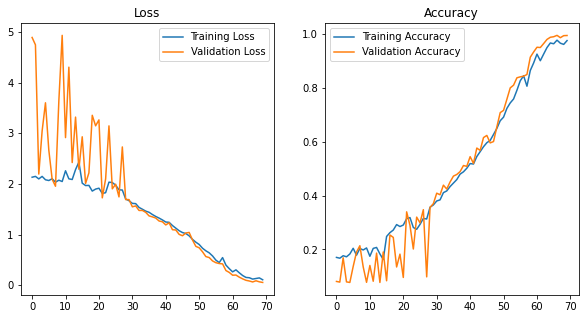

In [ ]:
train_accs = [acc.item() for acc in train_accs]
val_accs = torch.tensor(val_accs)  # ensure val_accs is a PyTorch tensor
test_accs = [acc.item() for acc in val_accs]

# plot the results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  # convert to numpy array
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


Test Accuracy of the model on the 2990 test images: 63.41137123745819 %


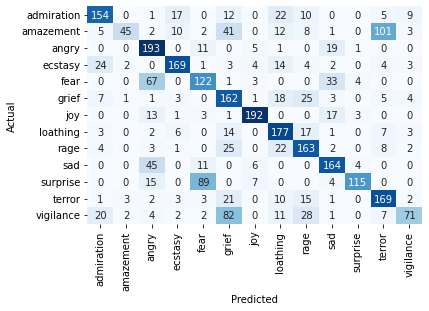

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


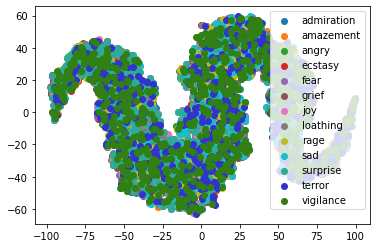

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define the label names and associated colors
label_names = ['admiration', 'amazement', 'angry','ecstasy','fear','grief','joy','loathing','rage','sad','surprise','terror','vigilance']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#2FAA96','#3232CC','#308014']

# Load the ResNet18 model with pretrained weights
resnet18 = models.resnet18(pretrained=False)

# Remove the last layer (softmax classifier) of the model
resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])

# Set the model to evaluation mode
resnet18.eval()

# Extract features from the convolutional layers of the model for all images in the train dataset
features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        # Pass the images through the model to extract features
        outputs = resnet18(images)
        # Flatten the features to a 2D array
        features.append(outputs.view(outputs.size(0), -1).numpy())
        # Save the corresponding labels
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE to reduce the dimensionality of the features to 2D
tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

# Plot the t-SNE graph with a legend
for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()

